# Notebook para gerar modelo que decide qual produto de financiamento do BNDES é o mais indicado para o cliente


**Objetivo**: O objetivo deste notebook é gerar um modelo que faz a predição de qual produto BNDES é mais adequado a um cliente de acordo com os dados. Para isso, o arquivo unificado "bndes_financiamentos.csv" gerado no notebook "BNDES - Normalizador de dataframes de financiamento" foi usado usado para treinar o modelo. O algoritmo utilizado é o Random Forest.


<img src="images/gerar_modelo_bndes.png">


A partir deles, iremos manipulá-los para ter apenas um arquivo final com os valores agrupados. O notebook está dividido nas seguintes etapas:
- 1. Lendo os arquivos csv gerado: leitura do csv bndes_financiamentos gerado no notebook "BNDES - Normalizador de dataframes de financiamento"
- 2. Fazendo análise exploratória: análise exploratória dos dados para entender melhor cada coluna
- 3. Filtrando: filtro de produtos
- 4. Treinando o modelo: treino de modelo usando o algoritmo random forest
- 5. Validando o modelo: validando os resultados do modelo. Modelo obteve mais de 0.9 de F1-score!
- 6. Salvando o modelo e encoder gerado: salvando o modelo treinado e a codificação das colunas categóricas

#### Sobre o modelo

Features usadas para identificar qual é o produto adequado:
- Natureza do cliente: natureza_do_cliente
- Porte do cliente: porte_do_cliente
- Valor a ser financiado: valor_contratado_reais
- Setor CNAE: setor_cnae
- Subsetor CNAE: subsetor_cnae
- Inovação: inovacao
- Ano de contratação: ano_contratado

Label:
- Produto: produto

### Importando os pacotes necessários

In [1]:
import os
import json
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score, classification_report

### Pegando o path do arquivo gerado

In [2]:
dirname = os.getcwd()
csv_path = os.path.join(dirname, "csv")
models_path = os.path.join(dirname, "models")
result_dataframe_path = os.path.join(csv_path, "output_csv", "bndes_financiamentos.csv")

### Funções

In [3]:
def encode_categorical(column_lst):
    encoder = LabelEncoder().fit(column_lst)
    encoded_column = encoder.transform(column_lst)
    encoder_dict = dict(zip(encoder.classes_, range(len(encoder.classes_))))
    return encoder_dict, encoded_column

def encode_label(df, label_column, training_encoder_dict):
    y_encoder_dict, y_encoded = encode_categorical(df[label_column])
    training_encoder_dict[label_column] = y_encoder_dict
    y = pd.Series(y_encoded)
    return y, training_encoder_dict
    
def encode_test_data(features_lst, training_encoder_dict, training_columns):
    test_data = []
    for feature, column in zip(features_lst, training_columns):
        encoded_feature_value = training_encoder_dict.get(column, {}).get(feature, None)
        if encoded_feature_value is None:
            test_data.append(feature)
        else:
            test_data.append(encoded_feature_value)
    return test_data

def encode_train_data(df, training_columns):
    training_encoder_dict = {}
    processed_columns_dict = {}
    for column in training_columns:
        if df[column].dtype == "O":
            encoder_dict, encoded_column = encode_categorical(df[column])
            training_encoder_dict[column] = encoder_dict
            processed_columns_dict[column] = encoded_column
        else:
            processed_columns_dict[column] = df[column].array
    X = pd.DataFrame(processed_columns_dict)
    return X, training_encoder_dict

def train_random_forest(df_x, df_y, label_dict, y_name):
    clf = RandomForestClassifier(random_state=1234, n_estimators=200, max_depth=15, criterion="gini")
    model = clf.fit(df_x, df_y)
    feature_importance_df = pd.DataFrame({"feature" : X.columns, "relevância da feature": model.feature_importances_})
    title = "Relevância das features na classificação de {}".format(y_name)
    ax = feature_importance_df.plot.bar(x="feature", y="relevância da feature", rot=90, title=title)
    return model

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle=True)
    return X_train, X_test, y_train, y_test

def plot_offer_confusion_matrix(model, X_test, y_test, label_dict, title_text, cmap=plt.cm.Greens):
    text = "{} matriz de confusão".format(title_text)
    title_options = [(text, None),
                     (text, "true")]
    
    predicted = product_model.predict(X_test)
    labels = [key for key, value in encoder_dict["produto"].items() if value in set(predicted)]
    
    for title, normalize in title_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        confusion_matrix = plot_confusion_matrix(
            estimator=model, 
            X=X_test,
            y_true=y_test,
            display_labels=labels,
            cmap=cmap,
            normalize=normalize,
            xticks_rotation=90,
            ax=ax
        )
        confusion_matrix.ax_.set_title(title)

    plt.show()

def get_metrics(model, X_test, y_test, label_dict):
    y_pred = model.predict(X_test)
    labels = [key for key, value in label_dict.items() if value in set(y_pred)]
    print(classification_report(y_test, y_pred, target_names=labels))
    f1_micro = f1_score(y_test, y_pred, average="micro")
    print("O F1 micro do modelo é {}".format(round(f1_micro, 3)))
    
def get_prediction(model, feature_data, encoder_dict, training_columns, label_column):
    encoded_test = encode_test_data(feature_data, encoder_dict, training_columns)
    encoded_prediction = model.predict([encoded_test])[0]
    prediction_prob = max(model.predict_proba([encoded_test])[0])
    decoder_dict = get_decoder_dict(encoder_dict[label_column])
    prediction = decoder_dict[encoded_prediction]
    return prediction, prediction_prob

def get_decoder_dict(encoder_dict):
    return {v: k for k, v in encoder_dict.items()}

def save_model(model, file_path):
    with open(file_path, "wb") as f:
        pickle.dump(model, f)
    
def read_model(file_path):
    with open(file_path, "rb") as f:
        loaded_model = pickle.load(f)
    return loaded_model

def save_encoder(encoder, file_path):
    with open(file_path, "w") as f:
        json.dump(encoder, f)
    
def read_encoder(file_path):
    with open(file_path) as f:
        loaded_encoder = json.load(f)
    return loaded_encoder

### 1. Lendo o arquivo csv gerado

In [4]:
full_df = pd.read_csv(result_dataframe_path, encoding="utf-8", sep=";", dtype={"cnpj_da_instituicao_financeira_credenciada": object, "cnpj": object})
full_df

,area_operacional,cliente,cnpj,cnpj_da_instituicao_financeira_credenciada,custo_financeiro,data_da_contratacao,descricao_do_projeto,fonte_de_recurso_desembolsos,forma_de_apoio,inovacao,...,situacao_do_contrato,subsetor_bndes,subsetor_cnae,subsetor_cnae_codigo,subsetor_cnae_nome,tipo_de_garantia,uf,valor_contratado_reais,valor_desembolsado_reais,ano_contratado
0,AREA DE OPERACOES E CANAIS DIGITAIS,BANCO DO BRASIL SA,***000000001**,00000000000191,TAXA FIXA,02/01/2002,SEM DESCRICAO,RECURSOS LIVRES - TESOURO,INDIRETA,NÃO,...,LIQUIDADO,AGROPECUÁRIA,AGROPECUÁRIA,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,DEFINIDA PELO AGENTE FINANCEIRO,MS,147393.0,147393.0,2002
1,AREA DE OPERACOES E CANAIS DIGITAIS,BANCO DO BRASIL SA,***000000001**,00000000000191,TAXA FIXA,02/01/2002,SEM DESCRICAO,RECURSOS LIVRES - TESOURO,INDIRETA,NÃO,...,LIQUIDADO,AGROPECUÁRIA,AGROPECUÁRIA,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,DEFINIDA PELO AGENTE FINANCEIRO,MG,60000.0,60000.0,2002
2,AREA DE OPERACOES E CANAIS DIGITAIS,BANCO DO BRASIL SA,***000000001**,00000000000191,TAXA FIXA,02/01/2002,SEM DESCRICAO,RECURSOS LIVRES - TESOURO,INDIRETA,NÃO,...,LIQUIDADO,AGROPECUÁRIA,AGROPECUÁRIA,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,DEFINIDA PELO AGENTE FINANCEIRO,MG,11700.0,11700.0,2002
3,AREA DE OPERACOES E CANAIS DIGITAIS,BANCO DO BRASIL SA,***000000001**,00000000000191,TAXA FIXA,02/01/2002,SEM DESCRICAO,RECURSOS LIVRES - TESOURO,INDIRETA,NÃO,...,LIQUIDADO,AGROPECUÁRIA,AGROPECUÁRIA,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,DEFINIDA PELO AGENTE FINANCEIRO,MS,150000.0,150000.0,2002
4,AREA DE OPERACOES E CANAIS DIGITAIS,BANCO DO BRASIL SA,***000000001**,00000000000191,TAXA FIXA,02/01/2002,SEM DESCRICAO,RECURSOS LIVRES - TESOURO,INDIRETA,NÃO,...,LIQUIDADO,AGROPECUÁRIA,AGROPECUÁRIA,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,DEFINIDA PELO AGENTE FINANCEIRO,MG,70000.0,70000.0,2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918197,AREA DE INDUSTRIA E SERVICOS,DURATEX S.A.,97837181000147,----------,TJLP,13/11/2012,INVESTIMENTOS FIXOS DESTINADOS AO AUMENTO DA C...,RECURSOS LIVRES - FAT / RECURSOS LIVRES - PRÓP...,DIRETA,NÃO,...,ATIVO,OUTRAS,MADEIRA,C1621800,FAB MADEIRA LAMINADA E CHPAS MADEIRA COMPENS P...,PESSOAL,RS,76512000.0,11974295.0,2012
1918198,AREA DE INDUSTRIA E SERVICOS,CAMERA AGROINDUSTRIAL S.A.,98248644000106,----------,TJLP,11/08/2005,REFORCO DE CAPITAL DE GIRO.,RECURSOS LIVRES - FAT,DIRETA,NÃO,...,LIQUIDADO,ALIMENTO E BEBIDA,PRODUTOS ALIMENTÍCIOS,C1041400,"FABRICACAO DE OLEOS VEGETAIS EM BRUTO, EXCETO ...",PESSOAL,RS,15000000.0,7523959.0,2005
1918199,AREA DE INDUSTRIA E SERVICOS,CAMERA AGROINDUSTRIAL S.A.,98248644000106,----------,TJLP,18/07/2012,EXPANSAO E MODERNIZACAO DE UNIDADE ESMAGADORA ...,RECURSOS LIVRES - PRÓPRIOS,DIRETA,NÃO,...,ATIVO,ALIMENTO E BEBIDA,PRODUTOS ALIMENTÍCIOS,C1041400,"FABRICACAO DE OLEOS VEGETAIS EM BRUTO, EXCETO ...",REAL / PESSOAL,RS,33749000.0,5177000.0,2012
1918200,AREA DE INDUSTRIA E SERVICOS,COOPERATIVA MISTA SAO LUIZ LTDA.,98338072000148,92816560000137,TAXA FIXA,04/12/2013,AQUISICAO DE PLANTA INDUSTRIAL COM CAPACIDADE ...,RECURSOS LIVRES - TESOURO,INDIRETA,NÃO,...,ATIVO,COMÉRCIO E SERVIÇOS,COMÉRCIO,G4623106,"COMERCIO ATACADISTA DE SEMENTES, FLORES, PLANT...",DEFINIDA PELO AGENTE FINANCEIRO,RS,16803817.0,16803817.0,2013


### 2. Fazendo análise exploratória dos dados

In [5]:
full_df.columns

Index(['area_operacional', 'cliente', 'cnpj',
       'cnpj_da_instituicao_financeira_credenciada', 'custo_financeiro',
       'data_da_contratacao', 'descricao_do_projeto',
       'fonte_de_recurso_desembolsos', 'forma_de_apoio', 'inovacao',
       'instituicao_financeira_credenciada', 'instrumento_financeiro', 'juros',
       'modalidade_de_apoio', 'municipio', 'municipio_codigo',
       'natureza_do_cliente', 'numero_do_contrato', 'porte_do_cliente',
       'prazo_amortizacao_meses', 'prazo_carencia_meses', 'produto',
       'setor_bndes', 'setor_cnae', 'situacao_do_contrato', 'subsetor_bndes',
       'subsetor_cnae', 'subsetor_cnae_codigo', 'subsetor_cnae_nome',
       'tipo_de_garantia', 'uf', 'valor_contratado_reais',
       'valor_desembolsado_reais', 'ano_contratado'],
      dtype='object')

In [6]:
full_df["setor_cnae"].value_counts()

COMERCIO E SERVICOS           1308007
INDUSTRIA DE TRANSFORMAÇÃO     302409
AGROPECUÁRIA E PESCA           293437
INDUSTRIA EXTRATIVA             14349
Name: setor_cnae, dtype: int64

In [7]:
full_df["subsetor_cnae"].value_counts()

TRANSPORTE TERRESTRE               721498
COMÉRCIO                           314791
AGROPECUÁRIA                       293437
CONSTRUÇÃO                         100247
PRODUTOS ALIMENTÍCIOS               75267
ATIV IMOBIL, PROFISSIONAL E ADM     63597
ATIV AUX TRANSPORTE E ENTREGA       35069
MINERAL NÃO METÁLICO                26447
BORRACHA E PLÁSTICO                 24190
PRODUTO DE METAL                    23434
MÁQUINAS E EQUIPAMENTOS             19375
MÓVEIS                              14471
INDÚSTRIA EXTRATIVA                 14349
QUÍMICA                             13740
ÁGUA, ESGOTO E LIXO                 12937
MADEIRA                             12394
ALOJAMENTO E ALIMENTAÇÃO            12299
CONFEC, VESTUÁRIO E ACESSÓRIOS      11705
ATIV FINANCEIRA E SEGURO            10640
METALURGIA                           9607
COQUE, PETRÓLEO E COMBUSTÍVEL        9280
VEÍCULO, REBOQUE E CARROCERIA        8915
SAÚDE E SERV SOCIAL                  8110
BEBIDAS                           

In [8]:
full_df["produto"].value_counts()

BNDES FINAME                                         1401812
BNDES AUTOMÁTICO                                      471657
BNDES FINAME LEASING                                   23366
BNDES FINAME AGRÍCOLA                                  12418
BNDES FINEM                                             6084
BNDES NÃO REEMBOLSÁVEL                                  1176
BNDES PROJECT FINANCE                                    815
BNDES LIMITE DE CRÉDITO                                  352
BNDES DEBENTURES SIMPLES                                 230
BNDES EMPRÉSTIMO PONTE                                   163
BNDES MICROCRÉDITO                                        64
OPERAÇÃO FINANCEIRA                                       40
BNDES DIRETO 10                                           12
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS                       6
OUTROS                                                     4
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA          1
BNDES RENEGOCIAÇÃO      

In [9]:
pd.DataFrame(full_df.groupby(["produto"]).natureza_do_cliente.unique())

,natureza_do_cliente
produto,
BNDES AUTOMÁTICO,"[PRIVADA, ADMINISTRAÇÃO PÚBLICA DIRETA - GOVER..."
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS,[PRIVADA]
BNDES DEBENTURES SIMPLES,"[PRIVADA, PÚBLICA INDIRETA]"
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA,[PRIVADA]
BNDES DIRETO 10,[PRIVADA]
BNDES EMPRÉSTIMO PONTE,"[PRIVADA, PÚBLICA INDIRETA]"
BNDES EXIM PÓS-EMBARQUE,[PÚBLICA INDIRETA]
BNDES FINAME,"[PRIVADA, ADMINISTRAÇÃO PÚBLICA DIRETA - GOVER..."
BNDES FINAME AGRÍCOLA,[PRIVADA]


In [10]:
pd.DataFrame(full_df.groupby(["produto"]).porte_do_cliente.unique())

,porte_do_cliente
produto,
BNDES AUTOMÁTICO,"[MICRO, PEQUENA, GRANDE, MÉDIA]"
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS,"[MÉDIA, GRANDE]"
BNDES DEBENTURES SIMPLES,"[GRANDE, MÉDIA]"
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA,[GRANDE]
BNDES DIRETO 10,[MÉDIA]
BNDES EMPRÉSTIMO PONTE,"[GRANDE, MÉDIA, MICRO]"
BNDES EXIM PÓS-EMBARQUE,[GRANDE]
BNDES FINAME,"[GRANDE, PEQUENA, MÉDIA, MICRO]"
BNDES FINAME AGRÍCOLA,"[MICRO, MÉDIA, PEQUENA, GRANDE]"


In [11]:
pd.DataFrame(full_df.groupby(["produto", "setor_bndes"]).subsetor_bndes.unique())

subsetor_bndes
produto                                           setor_bndes                                                         
BNDES AUTOMÁTICO                                  AGROPECUÁRIA                                          [AGROPECUÁRIA]
                                                  COMERCIO/SERVICOS                              [COMÉRCIO E SERVIÇOS]
                                                  INDUSTRIA          [ALIMENTO E BEBIDA, QUÍMICA E PETROQUÍMICA, OU...
                                                  INFRA-ESTRUTURA    [ATV. AUX. TRANSPORTES, TRANSPORTE RODOVIÁRIO,...
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS              COMERCIO/SERVICOS                              [COMÉRCIO E SERVIÇOS]
                                                  INDUSTRIA                                         [OUTRAS, MECÂNICA]
BNDES DEBENTURES SIMPLES                          COMERCIO/SERVICOS                              [COMÉRCIO E SERVIÇOS]
                                                  INDUSTRIA          [QUÍMICA E PETROQUÍMICA, ALIMENTO E BEBIDA, EX...
                                                  INFRAESTRUTURA     [SERV. UTILIDADE PÚBLICA, ENERGIA ELÉTRICA, TR...
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA INFRAESTRUTURA                               [ATV. AUX. TRANSPORTES]
BNDES DIRETO 10                                   COMERCIO/SERVICOS                              [COMÉRCIO E SERVIÇOS]
                                                  INDUSTRIA                                                   [OUTRAS]
                                                  INFRAESTRUTURA                             [SERV. UTILIDADE PÚBLICA]
BNDES EMPRÉSTIMO PONTE                            COMERCIO/SERVICOS                              [COMÉRCIO E SERVIÇOS]
                                                  INDUSTRIA          [EXTRATIVA, QUÍMICA E PETROQUÍMICA, METALURGIA...
                                                  INFRAESTRUTURA     [ATV. AUX. TRANSPORTES, TRANSPORTE FERROVIÁRIO...
BNDES EXIM PÓS-EMBARQUE                           INDUSTRIA                                                [EXTRATIVA]
BNDES FINAME                                      AGROPECUÁRIA                                          [AGROPECUÁRIA]
                                                  COMERCIO/SERVICOS                              [COMÉRCIO E SERVIÇOS]
                                                  INDUSTRIA          [ALIMENTO E BEBIDA, MECÂNICA, OUTRAS, EXTRATIV...
                                                  INFRA-ESTRUTURA    [TRANSPORTE RODOVIÁRIO, SERV. UTILIDADE PÚBLIC...
                                                  INFRAESTRUTURA     [ATV. AUX. TRANSPORTES, ENERGIA ELÉTRICA, CONS...
BNDES FINAME AGRÍCOLA                             AGROPECUÁRIA                                          [AGROPECUÁRIA]
                                                  COMERCIO/SERVICOS                              [COMÉRCIO E SERVIÇOS]
                                                  INDUSTRIA          [ALIMENTO E BEBIDA, TÊXTIL E VESTUÁRIO, OUTRAS...
                                                  INFRA-ESTRUTURA       [ATV. AUX. TRANSPORTES, TRANSPORTE RODOVIÁRIO]
BNDES FINAME LEASING                              AGROPECUÁRIA                                          [AGROPECUÁRIA]
                                                  COMERCIO/SERVICOS                              [COMÉRCIO E SERVIÇOS]
                                                  INDUSTRIA          [OUTRAS, QUÍMICA E PETROQUÍMICA, EXTRATIVA, AL...
                                                  INFRA-ESTRUTURA    [TRANSPORTE RODOVIÁRIO, SERV. UTILIDADE PÚBLIC...
BNDES FINEM                                       AGROPECUÁRIA                                          [AGROPECUÁRIA]
                                                  COMERCIO/SERVICOS                              [COMÉRCIO E SERVIÇOS]
                                                  INDUSTRI

In [12]:
pd.DataFrame(full_df.groupby(["produto", "setor_cnae"]).subsetor_cnae.unique())

subsetor_cnae
produto                                           setor_cnae                                                                   
BNDES AUTOMÁTICO                                  AGROPECUÁRIA E PESCA                                           [AGROPECUÁRIA]
                                                  COMERCIO E SERVICOS         [ATIV AUX TRANSPORTE E ENTREGA, COMÉRCIO, ARTE...
                                                  INDUSTRIA DE TRANSFORMAÇÃO  [BEBIDAS, PRODUTOS ALIMENTÍCIOS, QUÍMICA, MINE...
                                                  INDUSTRIA EXTRATIVA                                     [INDÚSTRIA EXTRATIVA]
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS              COMERCIO E SERVICOS                      [COMÉRCIO, ALOJAMENTO E ALIMENTAÇÃO]
                                                  INDUSTRIA DE TRANSFORMAÇÃO     [BORRACHA E PLÁSTICO, MÁQUINAS E EQUIPAMENTOS]
BNDES DEBENTURES SIMPLES                          COMERCIO E SERVICOS         [ELETRICIDADE E GÁS, ATIV FINANCEIRA E SEGURO,...
                                                  INDUSTRIA DE TRANSFORMAÇÃO  [COQUE, PETRÓLEO E COMBUSTÍVEL, PRODUTOS ALIME...
                                                  INDUSTRIA EXTRATIVA                                     [INDÚSTRIA EXTRATIVA]
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA COMERCIO E SERVICOS                           [ATIV AUX TRANSPORTE E ENTREGA]
BNDES DIRETO 10                                   COMERCIO E SERVICOS         [INFORMAÇÃO E COMUNICAÇÃO, ELETRICIDADE E GÁS,...
                                                  INDUSTRIA DE TRANSFORMAÇÃO                              [BORRACHA E PLÁSTICO]
BNDES EMPRÉSTIMO PONTE                            COMERCIO E SERVICOS         [ATIV AUX TRANSPORTE E ENTREGA, TRANSPORTE TER...
                                                  INDUSTRIA DE TRANSFORMAÇÃO            [QUÍMICA, METALURGIA, CELULOSE E PAPEL]
                                                  INDUSTRIA EXTRATIVA                                     [INDÚSTRIA EXTRATIVA]
BNDES EXIM PÓS-EMBARQUE                           INDUSTRIA EXTRATIVA                                     [INDÚSTRIA EXTRATIVA]
BNDES FINAME                                      AGROPECUÁRIA E PESCA                                           [AGROPECUÁRIA]
                                                  COMERCIO E SERVICOS         [COMÉRCIO, TRANSPORTE TERRESTRE, ARTES, CULTUR...
                                                  INDUSTRIA DE TRANSFORMAÇÃO  [BEBIDAS, EQUIP INFO, ELETRONICO, ÓTICO, MÁQUI...
                                                  INDUSTRIA EXTRATIVA                                     [INDÚSTRIA EXTRATIVA]
BNDES FINAME AGRÍCOLA                             AGROPECUÁRIA E PESCA                                           [AGROPECUÁRIA]
                                                  COMERCIO E SERVICOS         [ATIV AUX TRANSPORTE E ENTREGA, ATIV IMOBIL, P...
                                                  INDUSTRIA DE TRANSFORMAÇÃO  [PRODUTOS ALIMENTÍCIOS, TÊXTIL, MADEIRA, QUÍMI...
BNDES FINAME LEASING                              AGROPECUÁRIA E PESCA                                           [AGROPECUÁRIA]
                                                  COMERCIO E SERVICOS         [TRANSPORTE TERRESTRE, COMÉRCIO, CONSTRUÇÃO, I...
                                                  INDUSTRIA DE TRANSFORMAÇÃO  [BORRACHA E PLÁSTICO, QUÍMICA, PRODUTOS ALIMEN...
                                                  INDUSTRIA EXTRATIVA                                     [INDÚSTRIA EXTRATIVA]
BNDES FINEM                                       AGROPECUÁRIA E PESCA                                           [AGROPECUÁRIA]
                                                  COMERCIO E SERVICOS         [ADMINISTRAÇÃO PÚBLICA, ELETRICIDADE E GÁS, ÁG...
                                                  INDUSTRIA DE TRANSFORMAÇÃO  [QUÍMICA, PRODUTOS ALIMENTÍCIOS, OUTROS EQUIP ...
                  

In [13]:
pd.DataFrame(full_df.groupby(["produto"]).inovacao.unique())

,inovacao
produto,
BNDES AUTOMÁTICO,"[NÃO, SIM]"
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS,[NÃO]
BNDES DEBENTURES SIMPLES,[NÃO]
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA,[NÃO]
BNDES DIRETO 10,"[NÃO, SIM]"
BNDES EMPRÉSTIMO PONTE,[NÃO]
BNDES EXIM PÓS-EMBARQUE,[NÃO]
BNDES FINAME,"[NÃO, SIM]"
BNDES FINAME AGRÍCOLA,"[NÃO, SIM]"


In [14]:
pd.DataFrame(full_df.groupby(["produto"]).instrumento_financeiro.unique())

,instrumento_financeiro
produto,
BNDES AUTOMÁTICO,"[OUTROS, PRONAF INVESTIMENTO, MODERINFRA, MODE..."
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS,[BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS - INVEST...
BNDES DEBENTURES SIMPLES,"[OUTROS, MERCADO DE CAPITAIS]"
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA,[BNDES DEBÊNTURES SUSTENTÁVEIS E DE INFRAESTRU...
BNDES DIRETO 10,"[ECONOMIA DO CONHECIMENTO, EFICIÊNCIA ENERGÉTI..."
BNDES EMPRÉSTIMO PONTE,"[LOGÍSTICA - Modal Rodoviário, PROJETOS ESTRUT..."
BNDES EXIM PÓS-EMBARQUE,[BNDES EXIM PÓS-EMBARQUE]
BNDES FINAME,"[OUTROS, BK AQUISIÇÃO E COMERCIALIZAÇÃO, PSI -..."
BNDES FINAME AGRÍCOLA,"[PSI - BK - Demais Itens, MODERFROTA, PRODECOO..."


In [15]:
pd.DataFrame(full_df.groupby(["produto"]).modalidade_de_apoio.unique())

,modalidade_de_apoio
produto,
BNDES AUTOMÁTICO,[REEMBOLSÁVEL]
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS,[REEMBOLSÁVEL]
BNDES DEBENTURES SIMPLES,[REEMBOLSÁVEL]
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA,[REEMBOLSÁVEL]
BNDES DIRETO 10,[REEMBOLSÁVEL]
BNDES EMPRÉSTIMO PONTE,[REEMBOLSÁVEL]
BNDES EXIM PÓS-EMBARQUE,[REEMBOLSÁVEL]
BNDES FINAME,[REEMBOLSÁVEL]
BNDES FINAME AGRÍCOLA,[REEMBOLSÁVEL]


In [16]:
pd.DataFrame(full_df.groupby(["produto"]).ano_contratado.unique())

,ano_contratado
produto,
BNDES AUTOMÁTICO,"[2002, 2003, 2004, 2005, 2006, 2007, 2008, 200..."
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS,"[2019, 2020]"
BNDES DEBENTURES SIMPLES,"[2013, 2015, 2006, 2012, 2009, 2010, 2003, 200..."
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA,[2021]
BNDES DIRETO 10,[2020]
BNDES EMPRÉSTIMO PONTE,"[2015, 2012, 2002, 2014, 2005, 2008, 2006, 200..."
BNDES EXIM PÓS-EMBARQUE,[2013]
BNDES FINAME,"[2002, 2016, 2017, 2003, 2004, 2005, 2006, 200..."
BNDES FINAME AGRÍCOLA,"[2010, 2003, 2002, 2006, 2008, 2016, 2011, 201..."


### 3. Filtrando 

In [17]:
count_min = 20
full_df = full_df[full_df.groupby("produto").produto.transform("count")> 20].copy() 
full_df

,area_operacional,cliente,cnpj,cnpj_da_instituicao_financeira_credenciada,custo_financeiro,data_da_contratacao,descricao_do_projeto,fonte_de_recurso_desembolsos,forma_de_apoio,inovacao,...,situacao_do_contrato,subsetor_bndes,subsetor_cnae,subsetor_cnae_codigo,subsetor_cnae_nome,tipo_de_garantia,uf,valor_contratado_reais,valor_desembolsado_reais,ano_contratado
0,AREA DE OPERACOES E CANAIS DIGITAIS,BANCO DO BRASIL SA,***000000001**,00000000000191,TAXA FIXA,02/01/2002,SEM DESCRICAO,RECURSOS LIVRES - TESOURO,INDIRETA,NÃO,...,LIQUIDADO,AGROPECUÁRIA,AGROPECUÁRIA,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,DEFINIDA PELO AGENTE FINANCEIRO,MS,147393.0,147393.0,2002
1,AREA DE OPERACOES E CANAIS DIGITAIS,BANCO DO BRASIL SA,***000000001**,00000000000191,TAXA FIXA,02/01/2002,SEM DESCRICAO,RECURSOS LIVRES - TESOURO,INDIRETA,NÃO,...,LIQUIDADO,AGROPECUÁRIA,AGROPECUÁRIA,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,DEFINIDA PELO AGENTE FINANCEIRO,MG,60000.0,60000.0,2002
2,AREA DE OPERACOES E CANAIS DIGITAIS,BANCO DO BRASIL SA,***000000001**,00000000000191,TAXA FIXA,02/01/2002,SEM DESCRICAO,RECURSOS LIVRES - TESOURO,INDIRETA,NÃO,...,LIQUIDADO,AGROPECUÁRIA,AGROPECUÁRIA,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,DEFINIDA PELO AGENTE FINANCEIRO,MG,11700.0,11700.0,2002
3,AREA DE OPERACOES E CANAIS DIGITAIS,BANCO DO BRASIL SA,***000000001**,00000000000191,TAXA FIXA,02/01/2002,SEM DESCRICAO,RECURSOS LIVRES - TESOURO,INDIRETA,NÃO,...,LIQUIDADO,AGROPECUÁRIA,AGROPECUÁRIA,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,DEFINIDA PELO AGENTE FINANCEIRO,MS,150000.0,150000.0,2002
4,AREA DE OPERACOES E CANAIS DIGITAIS,BANCO DO BRASIL SA,***000000001**,00000000000191,TAXA FIXA,02/01/2002,SEM DESCRICAO,RECURSOS LIVRES - TESOURO,INDIRETA,NÃO,...,LIQUIDADO,AGROPECUÁRIA,AGROPECUÁRIA,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,DEFINIDA PELO AGENTE FINANCEIRO,MG,70000.0,70000.0,2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918197,AREA DE INDUSTRIA E SERVICOS,DURATEX S.A.,97837181000147,----------,TJLP,13/11/2012,INVESTIMENTOS FIXOS DESTINADOS AO AUMENTO DA C...,RECURSOS LIVRES - FAT / RECURSOS LIVRES - PRÓP...,DIRETA,NÃO,...,ATIVO,OUTRAS,MADEIRA,C1621800,FAB MADEIRA LAMINADA E CHPAS MADEIRA COMPENS P...,PESSOAL,RS,76512000.0,11974295.0,2012
1918198,AREA DE INDUSTRIA E SERVICOS,CAMERA AGROINDUSTRIAL S.A.,98248644000106,----------,TJLP,11/08/2005,REFORCO DE CAPITAL DE GIRO.,RECURSOS LIVRES - FAT,DIRETA,NÃO,...,LIQUIDADO,ALIMENTO E BEBIDA,PRODUTOS ALIMENTÍCIOS,C1041400,"FABRICACAO DE OLEOS VEGETAIS EM BRUTO, EXCETO ...",PESSOAL,RS,15000000.0,7523959.0,2005
1918199,AREA DE INDUSTRIA E SERVICOS,CAMERA AGROINDUSTRIAL S.A.,98248644000106,----------,TJLP,18/07/2012,EXPANSAO E MODERNIZACAO DE UNIDADE ESMAGADORA ...,RECURSOS LIVRES - PRÓPRIOS,DIRETA,NÃO,...,ATIVO,ALIMENTO E BEBIDA,PRODUTOS ALIMENTÍCIOS,C1041400,"FABRICACAO DE OLEOS VEGETAIS EM BRUTO, EXCETO ...",REAL / PESSOAL,RS,33749000.0,5177000.0,2012
1918200,AREA DE INDUSTRIA E SERVICOS,COOPERATIVA MISTA SAO LUIZ LTDA.,98338072000148,92816560000137,TAXA FIXA,04/12/2013,AQUISICAO DE PLANTA INDUSTRIAL COM CAPACIDADE ...,RECURSOS LIVRES - TESOURO,INDIRETA,NÃO,...,ATIVO,COMÉRCIO E SERVIÇOS,COMÉRCIO,G4623106,"COMERCIO ATACADISTA DE SEMENTES, FLORES, PLANT...",DEFINIDA PELO AGENTE FINANCEIRO,RS,16803817.0,16803817.0,2013


### 4. Treinando o modelo

In [18]:
training_columns = ["natureza_do_cliente", "porte_do_cliente", "valor_contratado_reais", "setor_cnae", "subsetor_cnae", "inovacao", "ano_contratado"]
X, encoder_dict = encode_train_data(full_df, training_columns)
X

,natureza_do_cliente,porte_do_cliente,valor_contratado_reais,setor_cnae,subsetor_cnae,inovacao,ano_contratado
0,3,1,147393.0,0,1,0,2002
1,3,1,60000.0,0,1,0,2002
2,3,1,11700.0,0,1,0,2002
3,3,1,150000.0,0,1,0,2002
4,3,1,70000.0,0,1,0,2002
...,...,...,...,...,...,...,...
1918172,3,0,76512000.0,2,23,0,2012
1918173,3,0,15000000.0,2,34,0,2005
1918174,3,0,33749000.0,2,34,0,2012
1918175,3,0,16803817.0,1,10,0,2013


RandomForestClassifier(max_depth=15, n_estimators=200, random_state=1234)

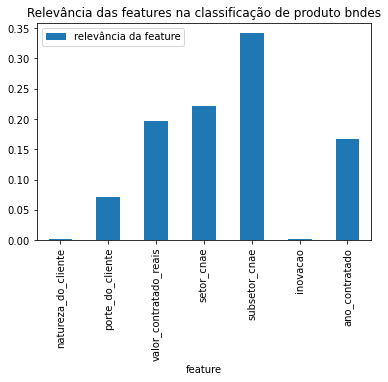

In [19]:
y_product, encoder_dict = encode_label(full_df, "produto", encoder_dict)
X_train, X_test, y_product_train, y_product_test = split_data(X, y_product)
product_model = train_random_forest(X_train, y_product_train, encoder_dict, y_name="produto bndes")
product_model

### 5. Validando o modelo

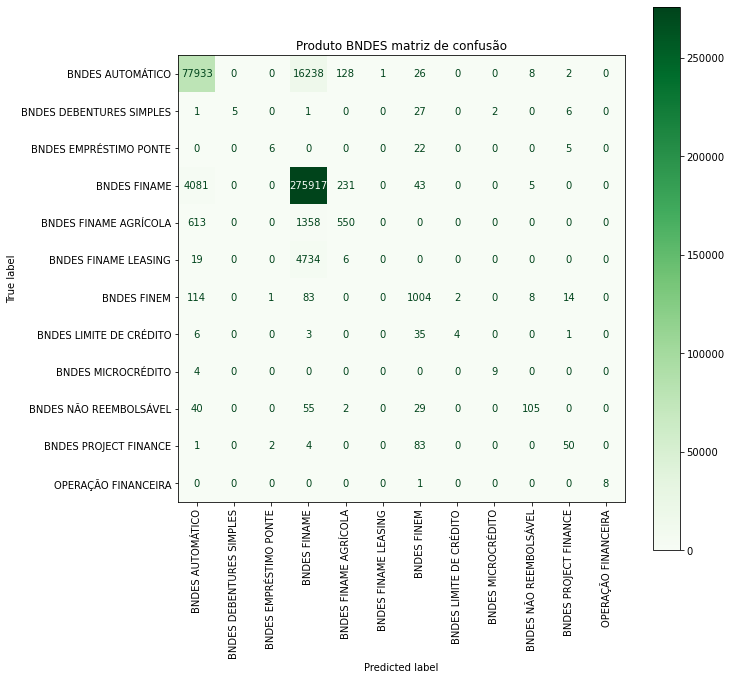

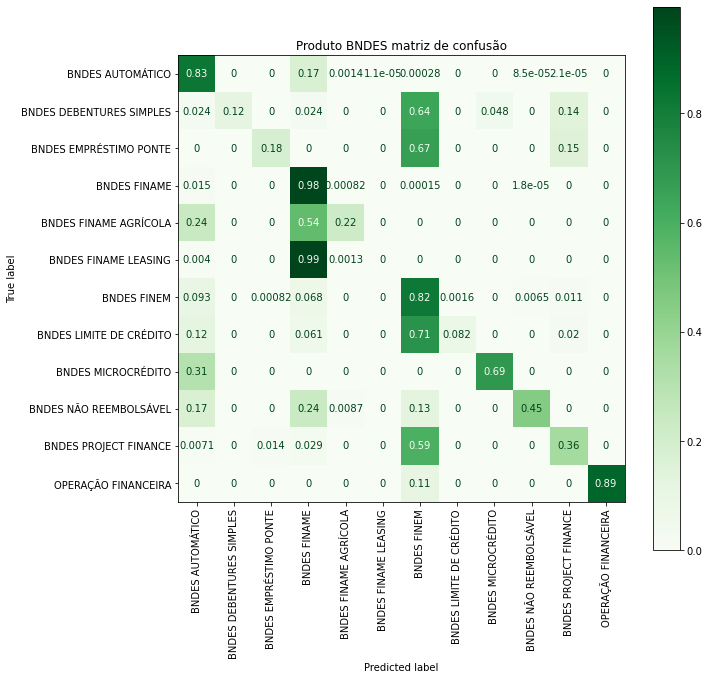

                          precision    recall  f1-score   support

        BNDES AUTOMÁTICO       0.94      0.83      0.88     94336
BNDES DEBENTURES SIMPLES       1.00      0.12      0.21        42
  BNDES EMPRÉSTIMO PONTE       0.67      0.18      0.29        33
            BNDES FINAME       0.92      0.98      0.95    280277
   BNDES FINAME AGRÍCOLA       0.60      0.22      0.32      2521
    BNDES FINAME LEASING       0.00      0.00      0.00      4759
             BNDES FINEM       0.79      0.82      0.80      1226
 BNDES LIMITE DE CRÉDITO       0.67      0.08      0.15        49
      BNDES MICROCRÉDITO       0.82      0.69      0.75        13
  BNDES NÃO REEMBOLSÁVEL       0.83      0.45      0.59       231
   BNDES PROJECT FINANCE       0.64      0.36      0.46       140
     OPERAÇÃO FINANCEIRA       1.00      0.89      0.94         9

                accuracy                           0.93    383636
               macro avg       0.74      0.47      0.53    383636
        

In [20]:
plot_offer_confusion_matrix(product_model, X_test, y_product_test, encoder_dict["produto"], "Produto BNDES")
get_metrics(product_model, X_test, y_product_test, encoder_dict["produto"])

In [21]:
training_columns

['natureza_do_cliente',
 'porte_do_cliente',
 'valor_contratado_reais',
 'setor_cnae',
 'subsetor_cnae',
 'inovacao',
 'ano_contratado']

In [22]:
encoder_dict["produto"]

{'BNDES AUTOMÁTICO': 0,
 'BNDES DEBENTURES SIMPLES': 1,
 'BNDES EMPRÉSTIMO PONTE': 2,
 'BNDES FINAME': 3,
 'BNDES FINAME AGRÍCOLA': 4,
 'BNDES FINAME LEASING': 5,
 'BNDES FINEM': 6,
 'BNDES LIMITE DE CRÉDITO': 7,
 'BNDES MICROCRÉDITO': 8,
 'BNDES NÃO REEMBOLSÁVEL': 9,
 'BNDES PROJECT FINANCE': 10,
 'OPERAÇÃO FINANCEIRA': 11}

In [23]:
feature_data = ["PRIVADA", "MICRO", 400000, "COMERCIO E SERVICOS", "COMÉRCIO", 1, 2021]
encoded_test = encode_test_data(feature_data, encoder_dict, training_columns)
product_model.predict([encoded_test])[0]

0

In [24]:
full_df[full_df["produto"] == 'BNDES FINEM'].natureza_do_cliente.value_counts()

PRIVADA                                             5199
ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO MUNICIPAL     455
PÚBLICA INDIRETA                                     225
ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO ESTADUAL      203
ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO FEDERAL         2
Name: natureza_do_cliente, dtype: int64

In [25]:
full_df[full_df["produto"] == 'BNDES FINEM'].porte_do_cliente.value_counts()

GRANDE     5230
MÉDIA       549
PEQUENA     185
MICRO       120
Name: porte_do_cliente, dtype: int64

In [26]:
full_df[full_df["produto"] == 'BNDES FINEM'].porte_do_cliente.value_counts()

GRANDE     5230
MÉDIA       549
PEQUENA     185
MICRO       120
Name: porte_do_cliente, dtype: int64

In [27]:
feature_data = ["PRIVADA", "MICRO", 400000, "COMERCIO E SERVICOS", "COMÉRCIO", 1, 2021]
get_prediction(product_model, feature_data, encoder_dict, training_columns, "produto")

('BNDES AUTOMÁTICO', 0.5435594445756774)

In [28]:
full_df[full_df["forma_de_apoio"] == 'INDIRETA'].porte_do_cliente.value_counts()

MICRO      897036
PEQUENA    410815
MÉDIA      303294
GRANDE     299529
Name: porte_do_cliente, dtype: int64

### 6. Salvando o modelo e encoder gerado

In [29]:
product_model_path = os.path.join(models_path, "modelo_produto.pkl")
encoder_path = os.path.join(models_path, "encoder.json")
save_model(product_model, product_model_path)
model_test = read_model(product_model_path)
get_prediction(model_test, feature_data, encoder_dict, training_columns, "produto")
save_encoder(encoder_dict, encoder_path)
read_encoder(encoder_path)

{'natureza_do_cliente': {'ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO ESTADUAL': 0,
  'ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO FEDERAL': 1,
  'ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO MUNICIPAL': 2,
  'PRIVADA': 3,
  'PÚBLICA INDIRETA': 4},
 'porte_do_cliente': {'GRANDE': 0, 'MICRO': 1, 'MÉDIA': 2, 'PEQUENA': 3},
 'setor_cnae': {'AGROPECUÁRIA E PESCA': 0,
  'COMERCIO E SERVICOS': 1,
  'INDUSTRIA DE TRANSFORMAÇÃO': 2,
  'INDUSTRIA EXTRATIVA': 3},
 'subsetor_cnae': {'ADMINISTRAÇÃO PÚBLICA': 0,
  'AGROPECUÁRIA': 1,
  'ALOJAMENTO E ALIMENTAÇÃO': 2,
  'ARTES, CULTURA E ESPORTE': 3,
  'ATIV AUX TRANSPORTE E ENTREGA': 4,
  'ATIV FINANCEIRA E SEGURO': 5,
  'ATIV IMOBIL, PROFISSIONAL E ADM': 6,
  'BEBIDAS': 7,
  'BORRACHA E PLÁSTICO': 8,
  'CELULOSE E PAPEL': 9,
  'COMÉRCIO': 10,
  'CONFEC, VESTUÁRIO E ACESSÓRIOS': 11,
  'CONSTRUÇÃO': 12,
  'COQUE, PETRÓLEO E COMBUSTÍVEL': 13,
  'COURO, ARTEFATO E CALÇADO': 14,
  'EDUCAÇÃO': 15,
  'ELETRICIDADE E GÁS': 16,
  'EQUIP INFO, ELETRONICO, ÓTICO': 17,
  'FARM

In [30]:
full_df.custo_financeiro.value_counts()

TAXA FIXA           1110517
TJLP                 533953
TJ462                145998
TLP                   72337
SELIC                 44671
US$ / CESTA            6199
TJ453                  2745
SEM CUSTO              1178
75% da SELIC            230
IPCA                    179
CDI                      51
OUTROS                   36
90% da SELIC             27
TJ6                      16
112% do CDI               4
104% do CDI               4
115% do CDI               4
117% do CDI               4
TAXA FIXA EM US$          3
110,3% do CDI             2
FAN                       2
102,5% do CDI             2
105% do CDI               2
109,8% do CDI             2
108% do CDI               2
104,1% do CDI             2
103,5% do CDI             2
104,4% do CDI             2
104,5% do CDI             1
101,75% do CDI            1
TJ3                       1
Name: custo_financeiro, dtype: int64